***1º Trabalho Prático - Processamento de Imagem e Visão (PIV)***


**1. Introdução**

**2. Leitura de Imagens**

(530, 706, 3)
(530, 706)


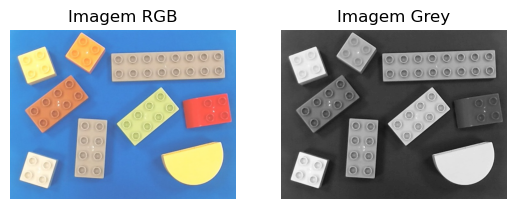

In [158]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Variavel de path
path_img = "../images/lego01.jpg"

# Ler imagens [MUDAR PATH PARA TESTAR COM OUTRA IMAGEM]
img = cv2.imread(path_img)



# Converter para RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Passar Imagem para Tons de Cinzento
img_gray = cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)

# Canais de cores = 3
print(np.shape(img))

# Mostrar imagem RGB
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Imagem RGB")
plt.axis("off")

print(np.shape(img_gray))

# Mostrar imagem Grey
plt.subplot(1,2,2)
plt.imshow(img_gray, cmap="gray")
plt.title("Imagem Grey")
plt.axis("off")
plt.show()

**3. Binarização**

A Binarização é [TODO].

Começamos por calcular o Histograma das Imagens para conseguirmos calcular o melhor valor de Thrashold

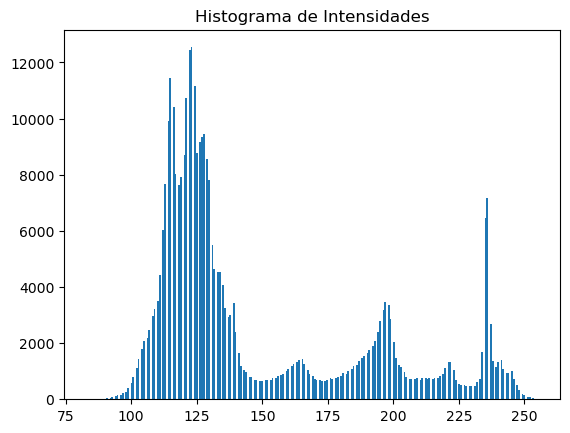

In [159]:
# Analisar o Histograma de Intensidades para calcular o melhor valor de THRESHHOLD
plt.hist(img_gray.ravel(), bins=256)
plt.title("Histograma de Intensidades")
plt.show()

In [160]:
# Suavizar ligeiramente para reduzir ruído
img_blur = cv2.GaussianBlur(img_gray, (5,5), 0)

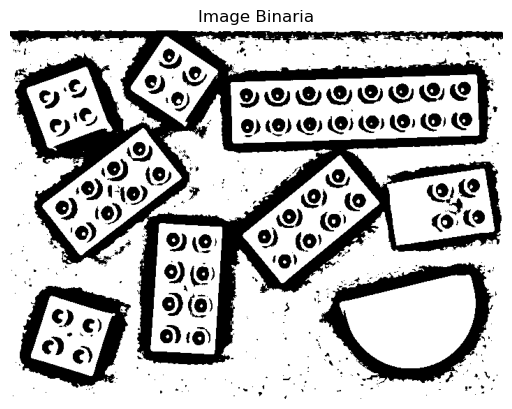

In [162]:
# Converter para binário
# 3) threshold adaptativo local (M3)
#    - blockSize: tamanho da vizinhança (ímpar, p.ex. 31, 41, 51, 61)
#    - C: constante subtraída (ajusta a agressividade; começa em 2–5)
blockSize = 51
C = 2
m3 = cv2.adaptiveThreshold(
    img_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,   # usa THRESH_BINARY_INV se quiseres peças=255
    blockSize, C
)

# Mostrar imagem [ALTERAR NUM DA IMAGEM PARA SER VISTA]
plt.imshow(m3, cmap="gray")
plt.title("Image Binaria")
plt.axis("off")  # Remove os eixos
plt.show()